In [1]:
import matplotlib.pyplot as plt
import importlib.util
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
import random
import os

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
def redshift_to_snap(redshift):
    correspondense = {6:'sn013', 8:'sn008', 10:'sn004'}
    return correspondense[redshift]

In [3]:
def update_df(df, h=0.6774):
    #df.set_index('ID', inplace=True)
    df['Q0/HaloMass']=df['Q0']/df['HaloMass']
    df['R_v^3/HaloMass']=df['HaloRadii']**3/df['HaloMass']
    df['StarMass']= df['HaloMass']*df['FractionStars']
    return

In [4]:
def plot_num_comparison(comparison_df, x_prop='StarMass', all_runs=False, save=False):
    h=0.6774
    x_labelsize = 50
    y_labelsize = 50

    length_major_ticks = 16
    length_minor_ticks = 8
    width_minor_ticks = 3
    width_major_ticks = 4
    labelsize_x_ticks = 35
    labelsize_y_ticks = 35
    legendsize = 50

    markersize = 280
    colorbar_labelsize = 50
    colorbar_ticklabelsize = 35

    axes_width = 3

    figure_width = 20
    figure_height = 20

    if x_prop == 'HaloMass':
        x_label = 'Halo Mass [$\log(M_{\mathrm{sun}})$]'
        mult = 1e10/h
    elif x_prop == 'StarMass':
        x_label = 'Stellar Mass [$\log(M_{\mathrm{sun}})$]'
        mult=1.0

    y_label = '$f_\mathrm{esc}$'

    plt.scatter(np.log10(comparison_df[x_prop]*mult), comparison_df['f_esc_1e5'], label=r'$10^5$', marker='x', s=markersize)
    plt.scatter(np.log10(comparison_df[x_prop]*mult), comparison_df['f_esc_1e6'], label=r'$10^6$', marker='+', s=markersize)
    if all_runs:
        plt.scatter(np.log10(comparison_df[x_prop]*mult), comparison_df['f_esc_5e6'], label=r'$5 \times 10^6$', marker='1', s=markersize)
    plt.yscale('log')
    plt.legend(fontsize=legendsize)
    plt.rc('axes', linewidth=axes_width)
    plt.rc('xtick', labelsize=labelsize_x_ticks) 
    plt.rc('ytick', labelsize=labelsize_y_ticks) 
    plt.xlabel(x_label, size=x_labelsize)
    plt.ylabel(y_label, size=y_labelsize)
    if not all_runs:
        plt.ylim(1e-3,1.)

    plt.rcParams["figure.figsize"] = (figure_width,figure_height)
    plt.tight_layout(rect=(0,0,1,0.7))
    if save:
        if all_runs:
            filename = f'/u/ivkos/analysis/plots/{x_prop}_numerical_test_all.pdf'
        else:
            filename = f'/u/ivkos/analysis/plots/{x_prop}_numerical_test.pdf'
        plt.savefig(filename, bbox_inches = 'tight')
    plt.show();
    return

In [5]:
def get_scatter(df, halo_prop='StarMass', bins=30, mode='median', threshhold=1e-3, y_axis='f_esc'):
    
    x_values = df.loc[:,halo_prop]
    edges = np.logspace(np.log10(x_values.min()),np.log10(x_values.max()), bins)
    
    means = []
    quantile16 = []
    quantile84 = []
    error = []
    centers = []
    variance = []
    frac_small_arr = []
    
    for i in range(len(edges)-1):
        sub_fesc = df[(edges[i]*(1-1e-10)<df[halo_prop]) & (df[halo_prop]<edges[i+1])][y_axis]
        
        if mode == 'median':
            means.append(sub_fesc.median())
        elif mode == 'mean':
            means.append(sub_fesc.mean())
        centers.append(np.exp((np.log(edges[i+1])+np.log(edges[i]))/2.))
        quantile16.append(sub_fesc.quantile(0.16))
        quantile84.append(sub_fesc.quantile(0.84))
        error.append(sub_fesc.std()/np.sqrt(sub_fesc.shape[0]))
        variance.append(sub_fesc.var())
        frac_small_arr.append((sub_fesc < threshhold).sum()/len(sub_fesc))
        
    means = np.array(means)
    quantile16 = np.array(quantile16)
    quantile84= np.array(quantile84)
    error = np.array(error) 
    centers = np.array(centers)
    variance = np.array(variance)
    frac_small_arr = np.array(frac_small_arr)
        
    return centers, means, quantile16, quantile84, error, variance, frac_small_arr

In [6]:
def plot_tng_comparison(dfs, halo_id=None, halo_prop='StarMass', bins=30, mode='median', y_threshold=1e-3, save=False):
        
    redshifts = [6,8,10]
    
    linewidth = 6
    markersize = 260
    markersize_scat = 60

    upper_y_threshold = 1.
    lower_y_threshold_lin = 0.
    lower_y_threshold_log = y_threshold
    
    size_label = 50
    x_tick_major_size = 16
    x_tick_major_width = 4
    x_tick_minor_size = 8
    x_tick_minor_width = 3
    legend_fontsize = 35
    legend_loc = 'upper right'
    fig_width = 25
    fig_height = 20
    axes_width = 3
    tick_labelsize = 35
    
    results = {}
    results['tng'] = {}
    results['tng2'] = {} 
    results['tng3'] = {}
    
    if halo_prop == 'HaloMass':
        x_label = 'Halo Mass [$\log(M_{\mathrm{sun}})$]'
    elif halo_prop == 'StarMass':    
        x_label = 'Stellar Mass [$\log(M_{\mathrm{sun}})$]'
    else:
        raise ValueError("Only defined for the properties 'HaloMass' and 'StarMass'")
        
    y_axis = 'f_esc' 
    y_label = r'$\langle f_\mathrm{esc} \rangle$'
    var_label = '$\mathrm{var}(f_\mathrm{esc})$'
    low_esc_label = '$P(f_\mathrm{esc}<10^{-3})$'
    
    centers_tng, means_tng, *_ = get_scatter(dfs['tng'], halo_prop=halo_prop, bins=bins, 
                                               mode=mode, y_axis='f_esc')
    centers_tng2, means_tng2, *_ = get_scatter(dfs['tng2'], halo_prop=halo_prop, bins=bins, 
                                               mode=mode, y_axis='f_esc')
    centers_tng3, means_tng3, *_ = get_scatter(dfs['tng3'], halo_prop=halo_prop, bins=bins, 
                                               mode=mode, y_axis='f_esc')

    results['tng']['x'] = centers_tng
    results['tng']['y'] = means_tng

    results['tng2']['x'] = centers_tng2
    results['tng2']['y'] = means_tng2

    results['tng3']['x'] = centers_tng3
    results['tng3']['y'] = means_tng3
    
    f = plt.figure()
    ax1 = plt.subplot()

    x_values_dust = np.log10(results['tng']['x'])
    y_values_dust = results['tng']['y']
    #ax1.plot(x_values_dust, y_values_dust, linewidth=linewidth,  color='red', marker='+', label=r'dust')
    ax1.scatter(x_values_dust, y_values_dust, color='red', marker='+', s=markersize, label=r'TNG50')

    x_values_no_dust = np.log10(results['tng2']['x'])
    y_values_no_dust = results['tng2']['y']
    #ax1.plot(x_values_no_dust, y_values_no_dust, linewidth=linewidth,  color='blue', marker='x', linestyle='--', label=r'no dust')
    ax1.scatter(x_values_no_dust, y_values_no_dust, color='blue', marker='x', s=markersize, label=r'TNG50-2')
    
    x_values_no_dust = np.log10(results['tng3']['x'])
    y_values_no_dust = results['tng3']['y']
    #ax1.plot(x_values_no_dust, y_values_no_dust, linewidth=linewidth,  color='blue', marker='x', linestyle='--', label=r'no dust')
    ax1.scatter(x_values_no_dust, y_values_no_dust, color='green', marker='1', s=markersize, label=r'TNG50-3')
            
    ax1.set_yscale('log')
    ax1.set_ylim(lower_y_threshold_log, upper_y_threshold)
    ax1.set_ylabel(y_label, size=size_label)
    ax1.set_xlabel(x_label, size=size_label)
    ax1.tick_params(length=x_tick_major_size, width=x_tick_major_width)
    ax1.tick_params(length=x_tick_minor_size, width=x_tick_minor_width, which='minor')
    ax1.legend(fontsize=legend_fontsize, loc=legend_loc)

    plt.rcParams["figure.figsize"] = (fig_width, fig_height)
    plt.rc('axes', linewidth=axes_width)
    plt.rc('xtick', labelsize=tick_labelsize) 
    plt.rc('ytick', labelsize=tick_labelsize) 
    if save:
        path = f'/u/ivkos/analysis/plots/tng_comparison_{halo_prop}.pdf'
        plt.savefig(path, bbox_inches = 'tight')
    plt.show();
    return

In [7]:
def update_df(df, h=0.6774):
    df['StarMass']= df['HaloMass']*df['FractionStars']*1e10/h
    return

In [8]:
df_1e6_full = pd.read_pickle('dfs/new_numerical_1e6.pickle')
df_5e6 = pd.read_pickle('dfs/new_numerical_5e6.pickle')
df = pd.read_pickle('dfs/full_esc.pickle')

In [9]:
merge_1 = df.merge(df_5e6[['ID', 'z', 'f_esc']], on=['ID', 'z'], suffixes=['_1e5', '_5e6'])
comparison_df = merge_1.merge(df_1e6_full[['ID', 'z', 'f_esc']], on=['ID', 'z'])
comparison_df['f_esc_1e6'] = comparison_df['f_esc']
update_df(comparison_df)

In [88]:
comparison_df2 = df.merge(df_1e6_full[['ID', 'z', 'f_esc', 'per_freq']], on=['ID', 'z'], suffixes=['_1e5', '_1e6'])
update_df(comparison_df2)

In [89]:
comparison_df3 = df.merge(df_5e6[['ID', 'z', 'f_esc', 'per_freq']], on=['ID', 'z'], suffixes=['_1e5', '_5e6'])
update_df(comparison_df3)

In [39]:
df_tng2 = pd.read_pickle('dfs/TNG50_2.pickle')
update_df(df_tng2)
df_tng3 = pd.read_pickle('dfs/TNG50_3.pickle')
update_df(df_tng3)
update_df(df)

In [40]:
dfs = {}
dfs['tng'] = df
dfs['tng2'] = df_tng2
dfs['tng3'] = df_tng3

In [44]:
df_1e4_full = pd.read_pickle('dfs/numerical_1e4.pickle')
df_1e5_full = pd.read_pickle('dfs/fid2.pickle')
df_1e6 = pd.read_pickle('dfs/numerical_1e6.pickle')
merge_1 = df_1e5_full.merge(df_1e6[['ID', 'z', 'f_esc']], on=['ID', 'z'], suffixes=['_1e5', '_1e6'])
comparison_df = merge_1.merge(df_1e4_full[['ID', 'z', 'f_esc']], on=['ID', 'z'])
comparison_df['f_esc_1e4'] = comparison_df['f_esc']
update_df(comparison_df)
del df_1e4_full
del df_1e5_full
del df_1e6

(0.1, 50)

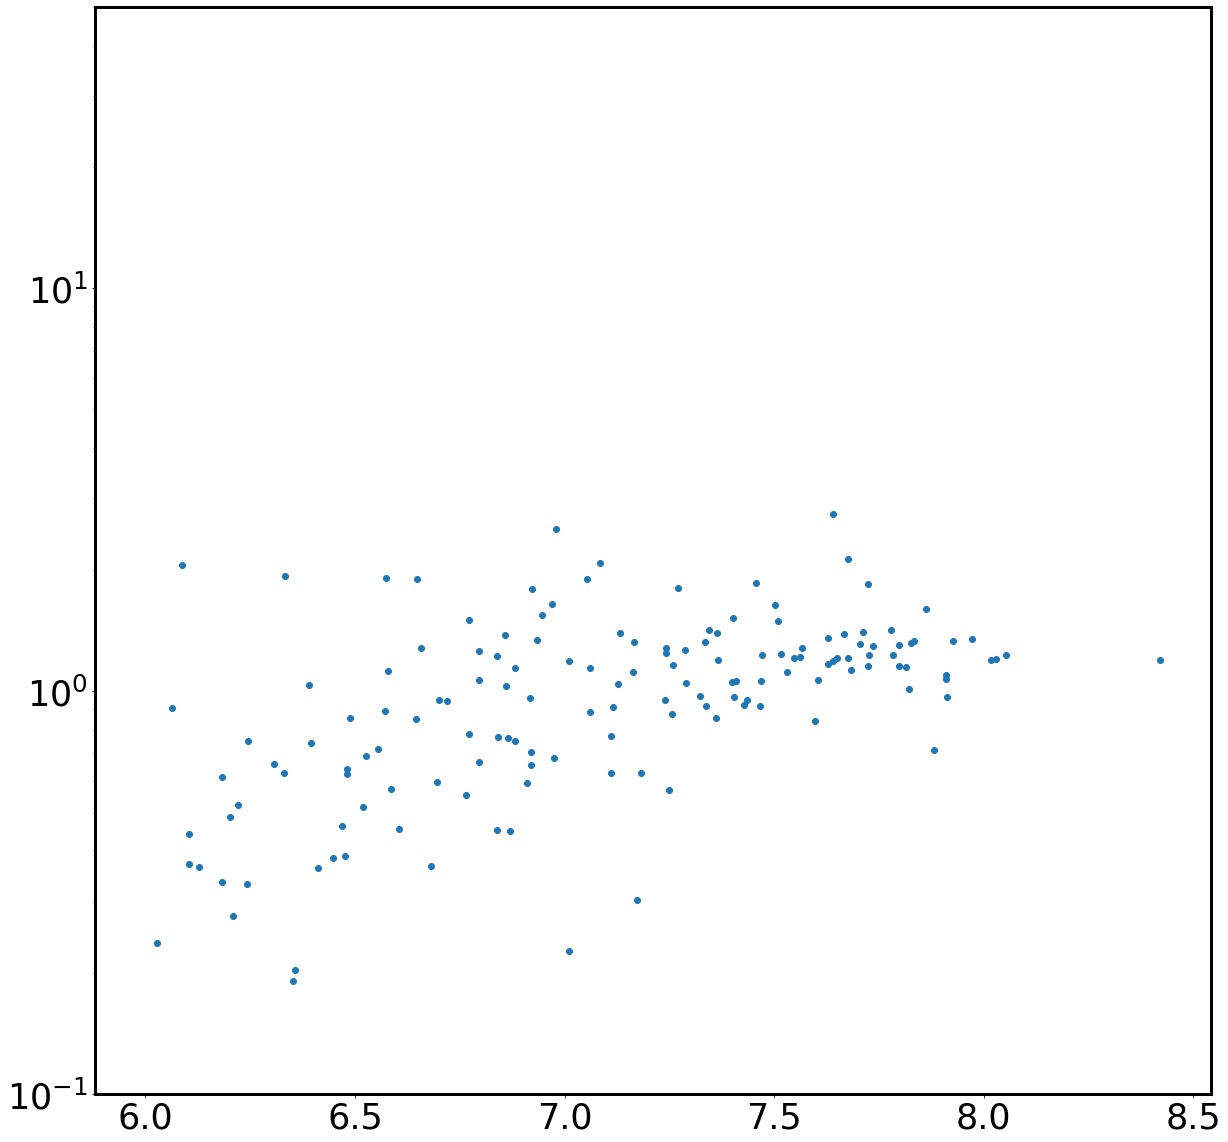

In [37]:
x_values = np.log10(comparison_df2.StarMass)
y_values = (comparison_df2.f_esc_1e6-comparison_df2.f_esc_1e5)/comparison_df2.f_esc_1e5
plt.scatter(x_values, y_values)
plt.yscale('log')
plt.ylim(0.1,50)

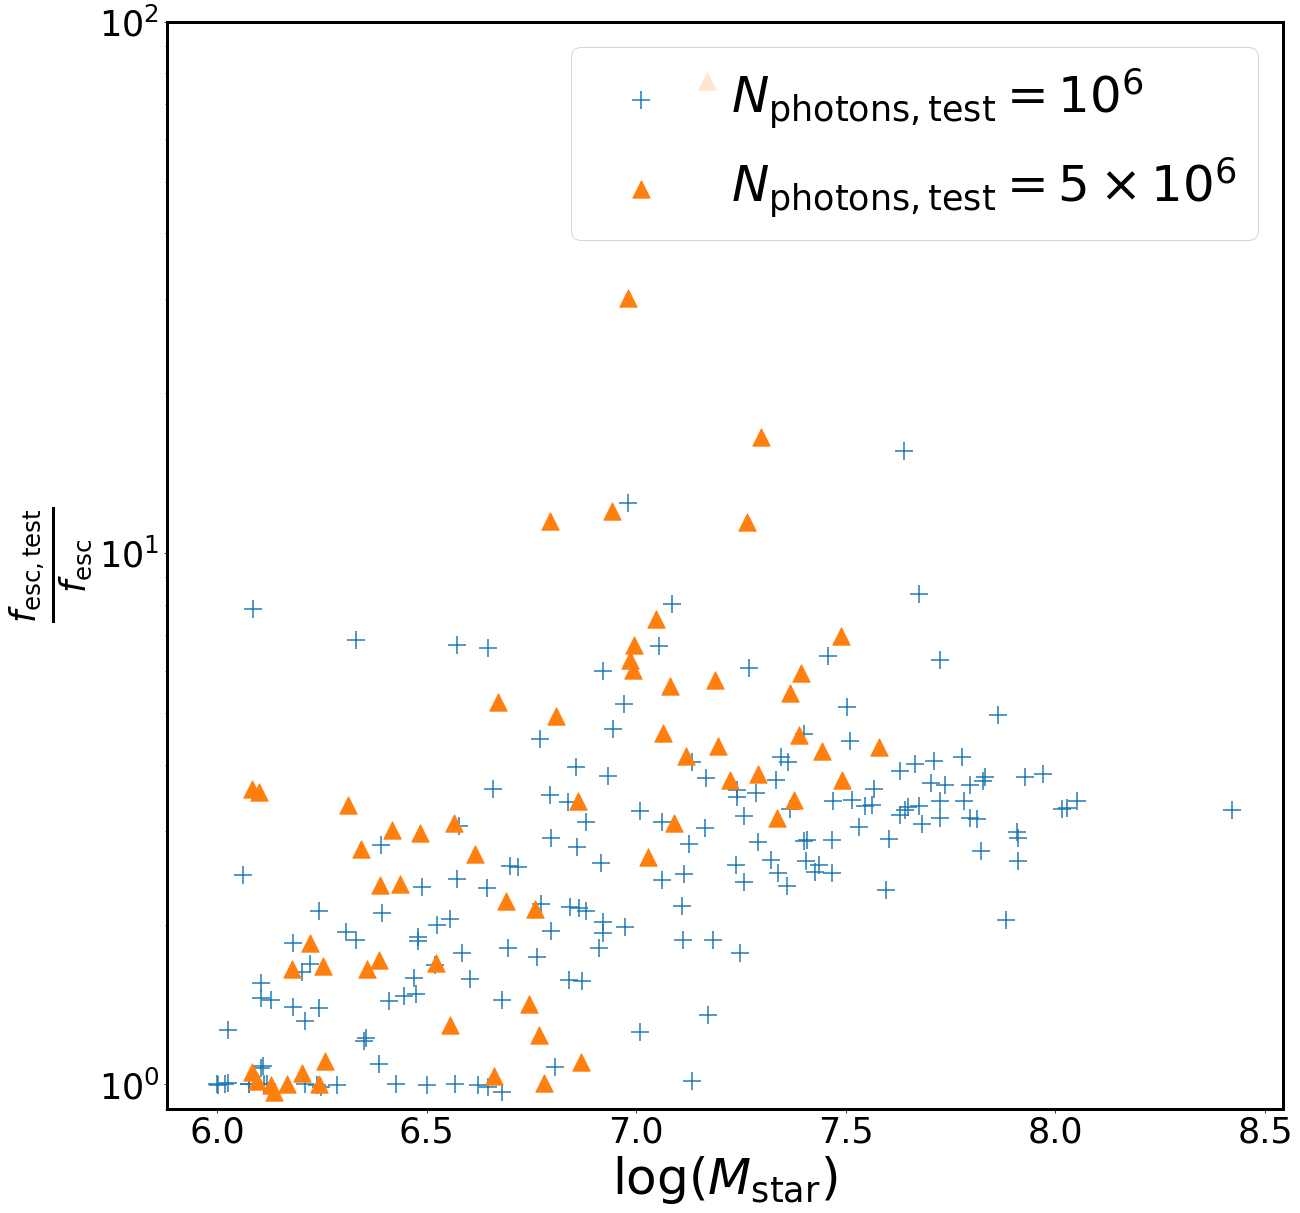

In [73]:
x_values = np.log10(comparison_df2.StarMass)
y_values = comparison_df2.f_esc_1e6/comparison_df2.f_esc_1e5
plt.scatter(x_values, y_values, s=300, marker='+', label='$N_\mathrm{photons, test}=10^6$')

x_values = np.log10(comparison_df3.StarMass)
y_values = comparison_df3.f_esc_5e6/comparison_df3.f_esc_1e5
plt.scatter(x_values, y_values, s=300, marker='^', label=r'$N_\mathrm{photons, test}=5 \times 10^6$')
plt.ylabel(r'$\frac{f_\mathrm{esc, test}}{f_\mathrm{esc}}$', size=50)
plt.xlabel(r'$\log(M_\mathrm{star})$', size=50)
plt.yscale('log')
plt.legend(fontsize=50)
plt.ylim(0.9,100);

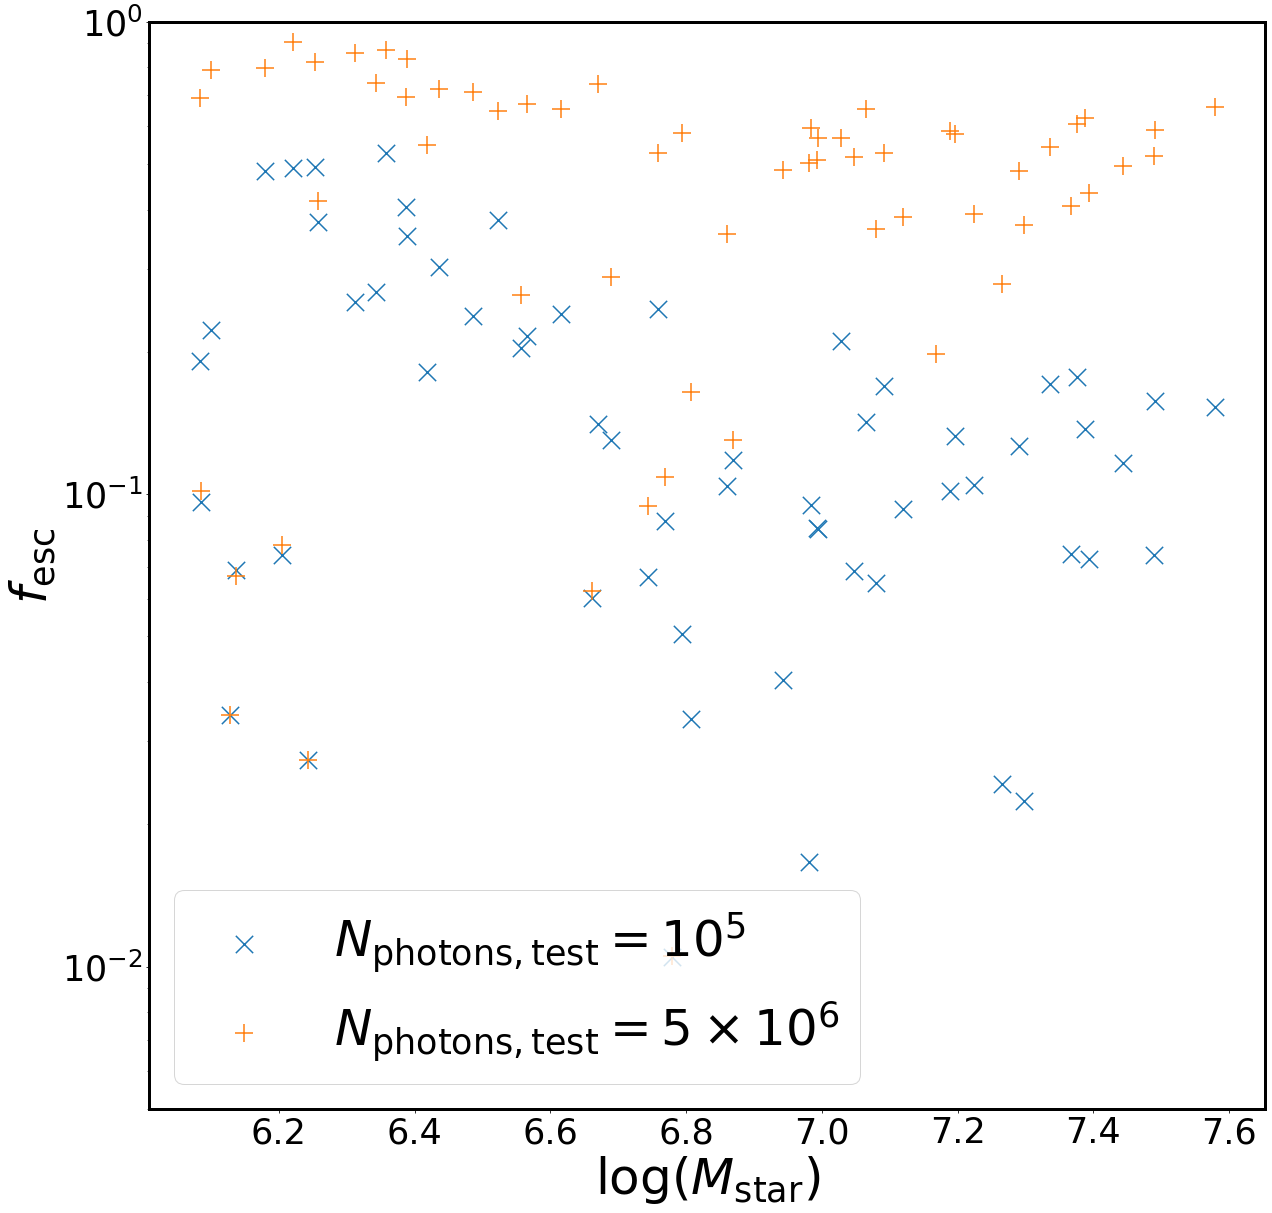

In [68]:
x_values = np.log10(comparison_df3.StarMass)
y_values = comparison_df3.f_esc_1e5
plt.scatter(x_values, y_values, s=300, marker='x', label='$N_\mathrm{photons, test}=10^5$')

x_values = np.log10(comparison_df3.StarMass)
y_values = comparison_df3.f_esc_5e6
plt.scatter(x_values, y_values, s=300, marker='+', label=r'$N_\mathrm{photons, test}=5 \times 10^6$')
plt.ylabel(r'$f_\mathrm{esc}$', size=50)
plt.xlabel(r'$\log(M_\mathrm{star})$', size=50)
plt.yscale('log')
plt.legend(fontsize=50)
plt.ylim(0.005,1);

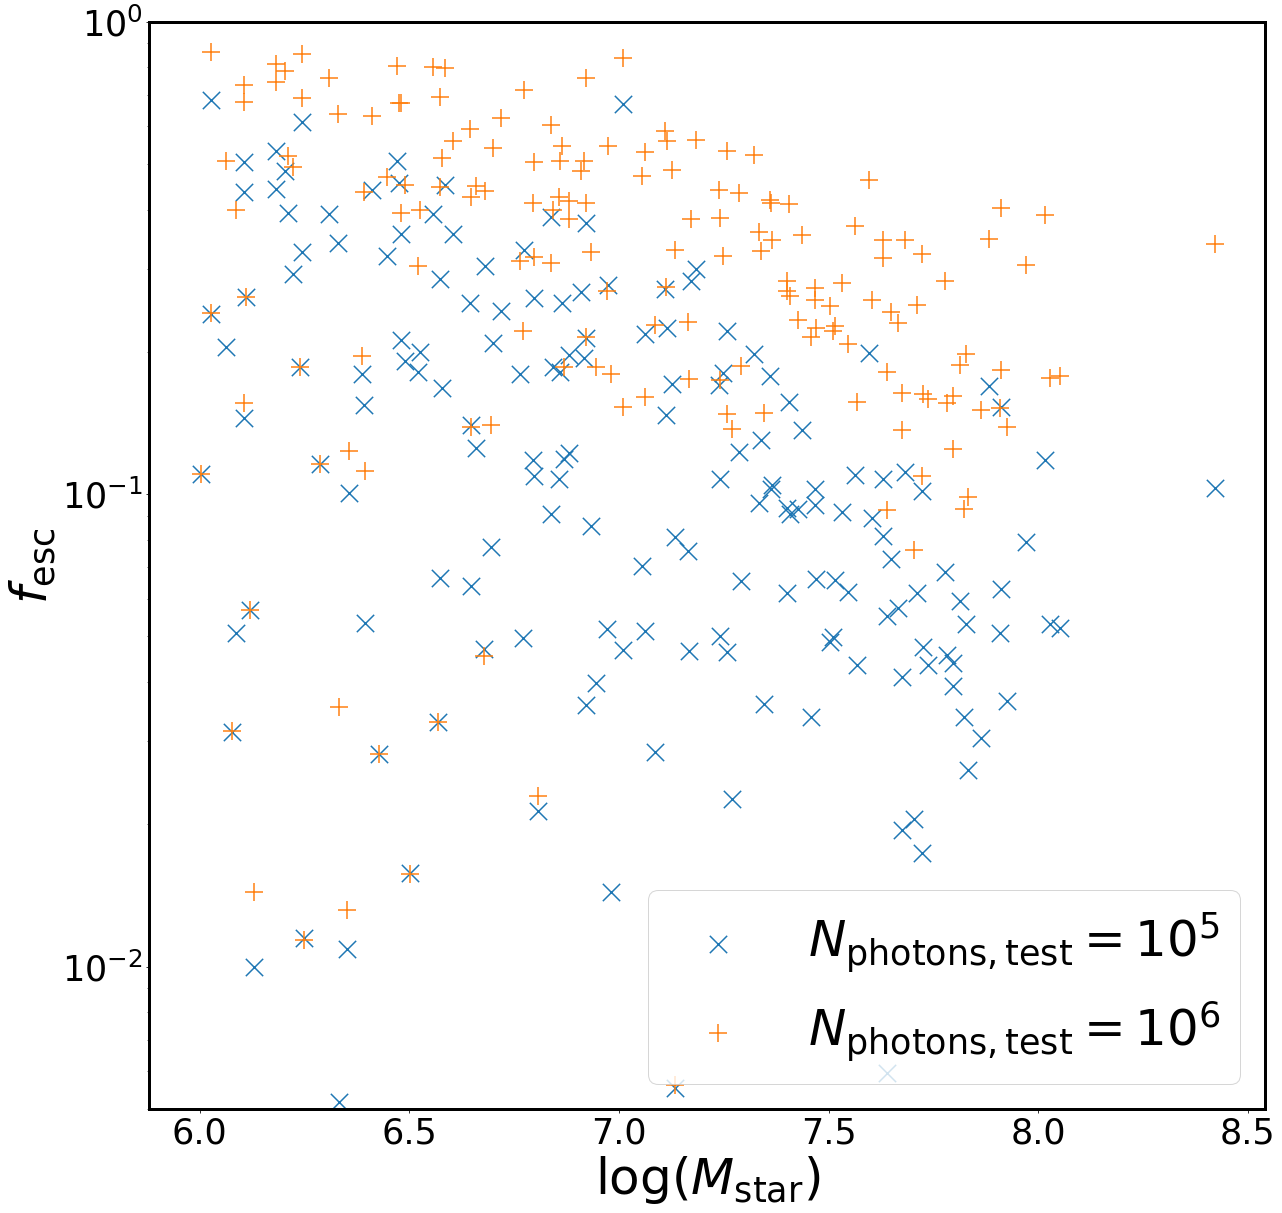

In [69]:
x_values = np.log10(comparison_df2.StarMass)
y_values = comparison_df2.f_esc_1e5
plt.scatter(x_values, y_values, s=300, marker='x', label='$N_\mathrm{photons, test}=10^5$')

x_values = np.log10(comparison_df2.StarMass)
y_values = comparison_df2.f_esc_1e6
plt.scatter(x_values, y_values, s=300, marker='+', label=r'$N_\mathrm{photons, test}=10^6$')
plt.ylabel(r'$f_\mathrm{esc}$', size=50)
plt.xlabel(r'$\log(M_\mathrm{star})$', size=50)
plt.yscale('log')
plt.legend(fontsize=50)
plt.ylim(0.005,1);

In [236]:
df_test = pd.read_pickle('dfs/fid2.pickle')

In [244]:
df_test[(df_test.ID==672) & (df_test.z==6)].f_esc

895    0.025952
Name: f_esc, dtype: float64

In [192]:
comparison_df3[comparison_df3.ID==1029].GridSize

30    93
Name: GridSize, dtype: int64

In [219]:
test = df[(df.ID==672) & (df.z==6)]

In [243]:
df_test.f_esc

0        0.002808
1        0.061407
2        0.000947
3        0.059300
4        0.102726
           ...   
10658    0.147129
10659    0.005572
10660    0.082814
10661    0.013817
10662    0.174854
Name: f_esc, Length: 10663, dtype: float64

In [234]:
np.log10(test.HaloMass/0.6774*1e10)

890    10.577773
Name: HaloMass, dtype: float64

In [224]:
test.per_source.values

array([array([2.78378027e-40, 5.65760252e-37, 4.87659614e-46, ...,
                  nan,            nan, 5.77830980e-01])], dtype=object)

In [215]:
df[df.ID==672][['f_esc','z']]

,f_esc,z
890,0.032748,6
5309,0.021638,8
7570,0.255976,10


In [191]:
comparison_df3[comparison_df3.ID==1029].f_esc_1e5
comparison_df3[comparison_df3.ID==1029].f_esc_5e6

30    0.002568
Name: f_esc_1e5, dtype: float64

30    0.198295
Name: f_esc_5e6, dtype: float64

,ID,GridSize,f_esc_1e5,f_esc_5e6
13,1812,130,0.074181,0.518824
22,8727,100,0.084667,0.510517
28,2634,88,0.094889,0.595863
30,1029,93,0.002568,0.198295
37,2310,83,0.040398,0.484773
39,3203,80,0.050570,0.580679
44,919,184,0.024297,0.277886
46,1940,70,0.084233,0.566032
47,1201,86,0.016678,0.502794
50,1285,101,0.022462,0.371483


In [199]:
from crashpy.dataclasses.simulation import LoadedSimulation as Sim
from crashpy.escapeFraction import computeEscFrac
from crashpy import utilities
import h5py

seed = 2
prec = 0.05
r_scale = 1.0
threads = 1

#compute_f_esc(prec=config.f_esc_prec, r_scales=config.f_esc_rscales, overwrite=config.f_esc_overwrite)
simpath_1e5  = '/freya/ptmp/mpa/mglatzle/TNG_f_esc/full_esc/run/L35n2160TNG/sn008/g1029'
simpath_5e6  = '/freya/ptmp/mpa/mglatzle/TNG_f_esc/new_numerical_5e6/run/L35n2160TNG/sn008/g1029'

sim_1e5 = Sim(simpath_1e5)
sim_5e6 = Sim(simpath_5e6)

physfiles_1e5 = sim_1e5.getAllphysfiles()
physfiles_1e5 = sim_5e6.getAllphysfiles()

result_1e5 = computeEscFrac(sim=sim_1e5, physfileNumber=physfiles_1e5[4].info['number'],
                               delta_rel=prec, r_scale=r_scale,
                               n_threads=threads,
                               seed=seed)

result_5e6 = computeEscFrac(sim=sim_5e6, physfileNumber=physfiles_1e5[4].info['number'],
                               delta_rel=prec, r_scale=r_scale,
                               n_threads=threads,
                               seed=seed)

In [200]:
result_1e5['cum']
result_5e6['cum']

0.002642088876139741

0.2025633179218717

In [201]:
result_1e5.keys()

dict_keys(['freqs', 'emitted_photons', 'escaped_photons', 'per_source', 'per_freq', 'cum', 'n_iterations', 'chunk_size'])

In [202]:
def redshift_to_snap(redshift):
    snapnames = {6:'sn013', 8:'sn008', 10:'sn004'}
    return snapnames[redshift]

def source_dist_lum(ID, redshift, conf, side_length):
    snap = redshift_to_snap(redshift)
    path_sources = f'/ptmp/mpa/mglatzle/TNG_f_esc/{conf}/run/L35n2160TNG/{snap}/g{ID}/Input/sources_ic00.in'
    
    # 0.5 is needed to take into account that the sources are at the center of the grid voxel, move origin to halo center
    coord = pd.read_csv(path_sources, delim_whitespace=True, header=None, usecols=[0,1,2])+0.5-side_length/2
    lum = pd.read_csv(path_sources, delim_whitespace=True, header=None, usecols=[3])
    rel_dist = np.sqrt(np.sum(coord**2, axis=1))*2/side_length
    
    return rel_dist

In [285]:
dist_1812 = np.array(source_dist_lum(ID=1812, redshift=6, conf='full_esc', side_length=130))
dist_1029 = np.array(source_dist_lum(ID=1029, redshift=8, conf='full_esc', side_length=93))
dist_663 = np.array(source_dist_lum(ID=663, redshift=10, conf='full_esc', side_length=75))

In [325]:
per_freq_1812_5e6 = df_5e6[df_5e6.ID==1812].per_freq.values[0]
per_freq_1029_5e6 = df_5e6[df_5e6.ID==1029].per_freq.values[0]
per_freq_663_5e6 = df_5e6[df_5e6.ID==663].per_freq.values[0]

per_freq_1812_1e5 = df[(df.ID==1812) & (df.z==6)].per_freq.values[0]
per_freq_1029_1e5 = df[(df.ID==1029) & (df.z==8)].per_freq.values[0]
per_freq_663_1e5 = df[(df.ID==663) & (df.z==10)].per_freq.values[0]

In [328]:
h_p = 6.62607004e-34
e = 1.60217662e-19
freq_energy = df[(df.ID==663) & (df.z==10)].frequencies.values[0]*h_p/e

Text(0, 0.5, '$\\langle f_\\mathrm{esc} \\rangle$')

Text(0.5, 0, '$ E(\\gamma)[\\mathrm{eV}] $')

(0.0, 1.0)

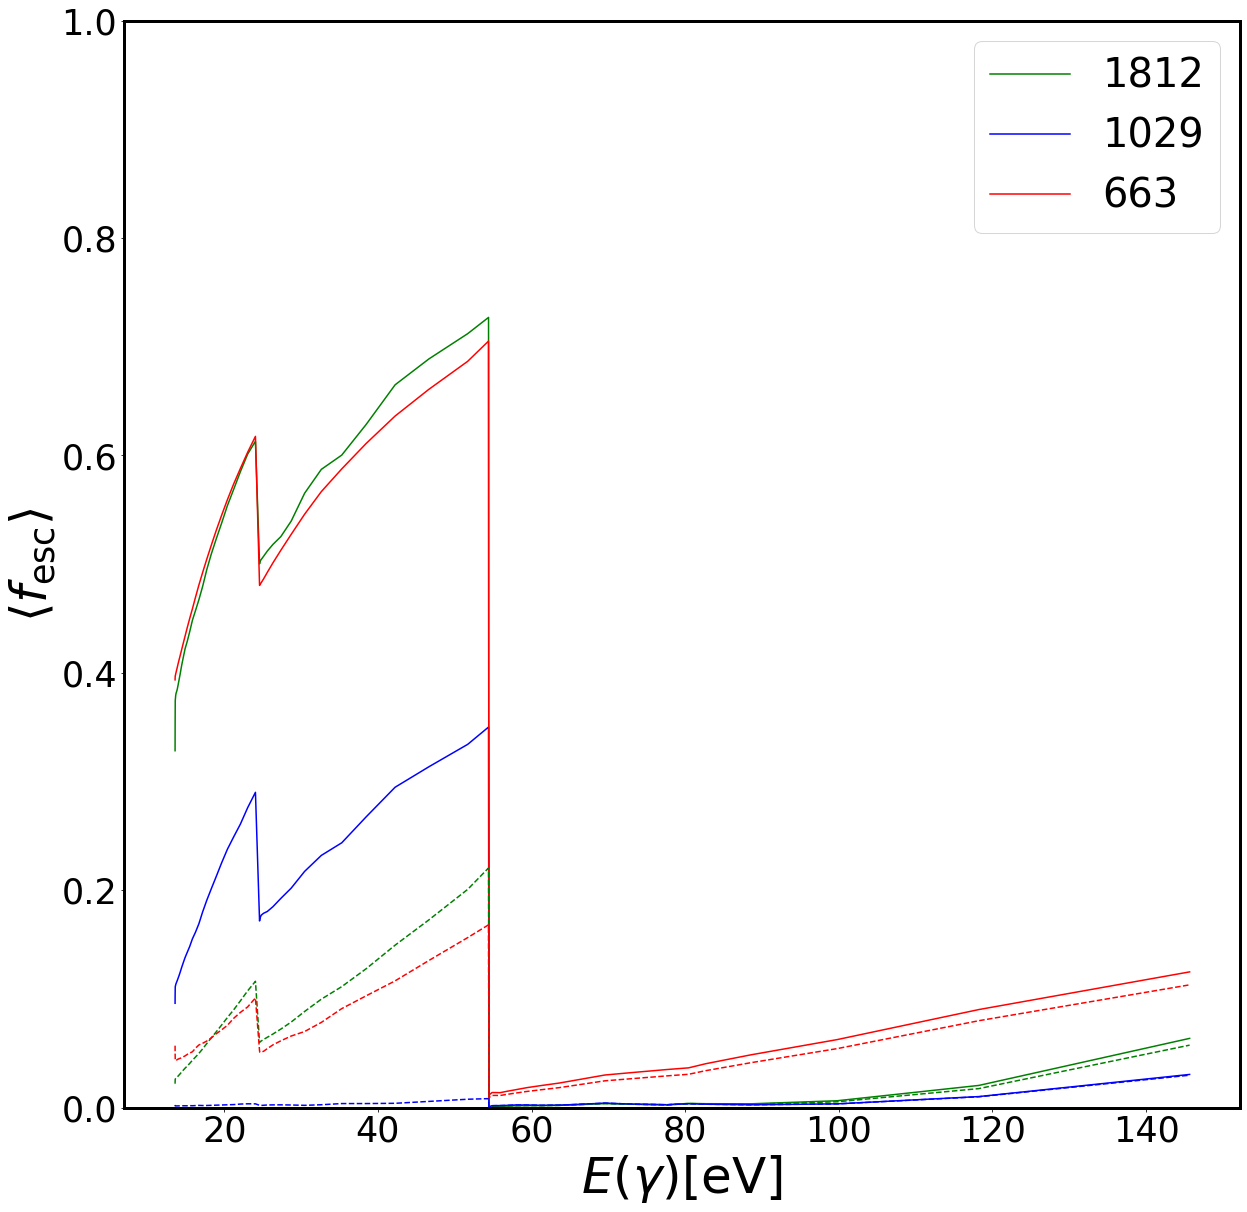

In [336]:
plt.plot(freq_energy, per_freq_1812_5e6, label='1812', color='green')
plt.plot(freq_energy, per_freq_1029_5e6, label='1029', color='blue')
plt.plot(freq_energy, per_freq_663_5e6, label='663', color='red')
plt.plot(freq_energy, per_freq_1812_1e5, linestyle='--', color='green')
plt.plot(freq_energy, per_freq_1029_1e5, linestyle='--', color='blue')
plt.plot(freq_energy, per_freq_663_1e5, linestyle='--', color='red')
plt.legend(fontsize=40)
plt.ylabel(r'$\langle f_\mathrm{esc} \rangle$', size=50)
plt.xlabel(r'$ E(\gamma)[\mathrm{eV}] $', size=50)
#plt.yscale('log')
plt.ylim([0,1.0])

In [309]:
ratio_1812 = comparison_df3[comparison_df3.ID==1812].per_source.values[0]/df_5e6[df_5e6.ID==1812].per_source.values[0]
ratio_1029 = comparison_df3[comparison_df3.ID==1029].per_source.values[0]/df_5e6[df_5e6.ID==1029].per_source.values[0]
ratio_663 = comparison_df3[comparison_df3.ID==663].per_source.values[0]/df_5e6[df_5e6.ID==663].per_source.values[0]

In [306]:
comparison_df3[comparison_df3.ID==663].per_source

58    [5.887854882599587e-17, 2.3964642453928703e-07...
Name: per_source, dtype: object

In [305]:
df_5e6[df_5e6.ID==663].per_source

68    [2.3300233589663327e-16, 0.07592677768255546, ...
Name: per_source, dtype: object

(0.0, 1.2)

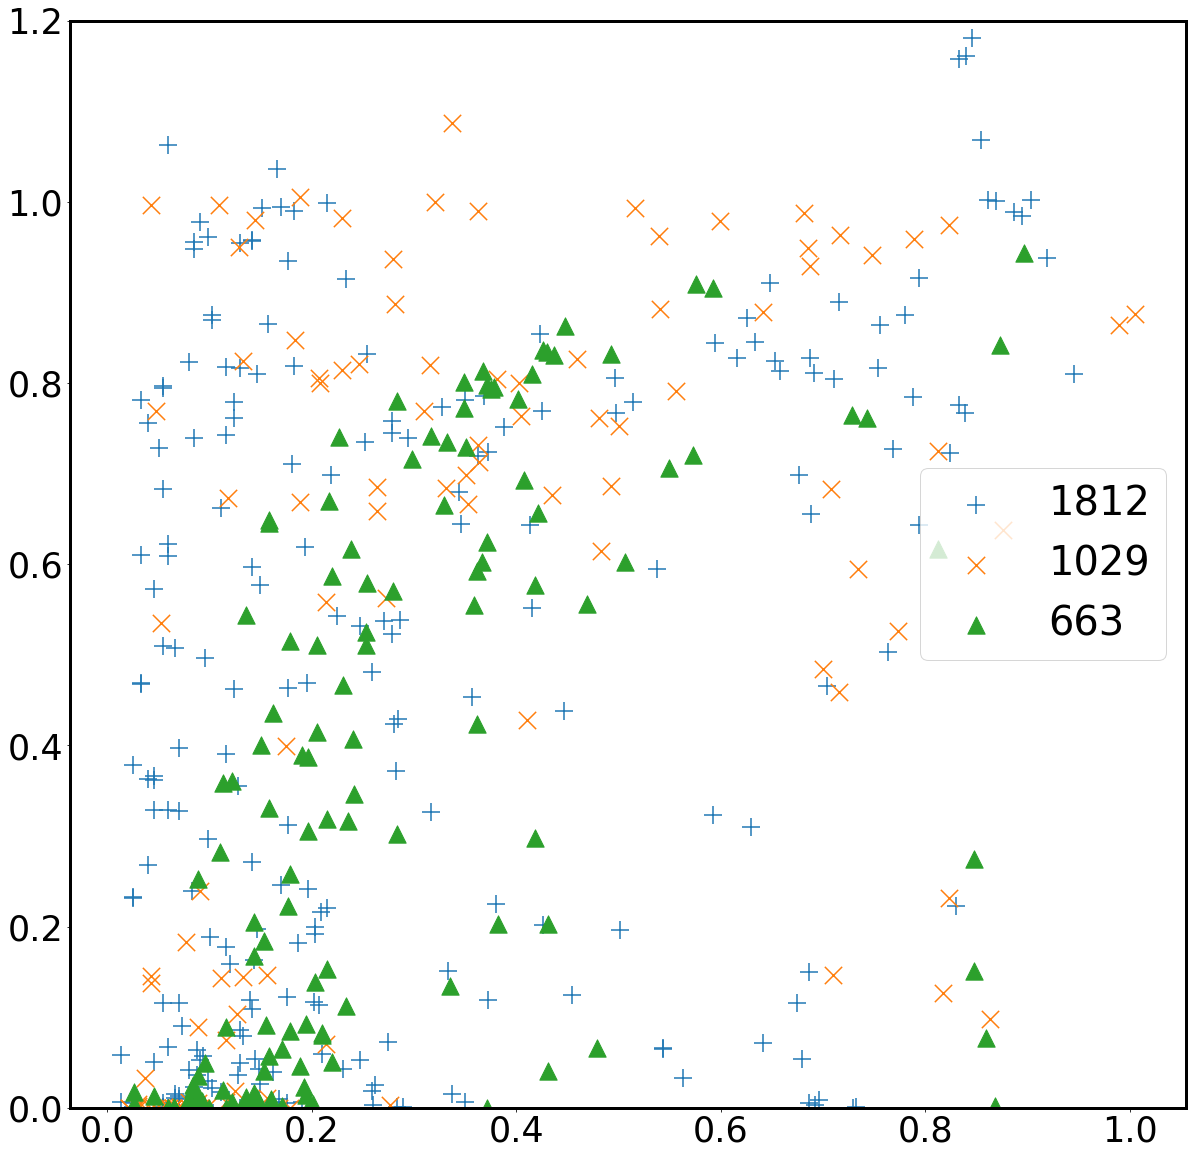

In [316]:
plt.scatter(dist_1812, ratio_1812, s=300, marker='+', label='1812')
plt.scatter(dist_1029, ratio_1029, s=300, marker='x', label='1029')
plt.scatter(dist_663, ratio_663, s=300, marker='^', label='663')
plt.legend(fontsize=40)
#plt.yscale('log')
plt.ylim([0,1.2])

In [392]:
comparison_df3[comparison_df3.ID==1029].f_esc_5e6

30    0.198295
Name: f_esc_5e6, dtype: float64

In [388]:
df_5e6[df_5e6.ID==1029].f_esc

30    0.198295
Name: f_esc, dtype: float64

In [377]:
pre_conv_1e6 = pd.read_pickle('dfs/convergence_test_1e6.pickle')
pre_conv_5e6 = pd.read_pickle('dfs/new_numerical_5e6.pickle')
conv_1e7 = pd.read_pickle('dfs/convergence_test_1e7.pickle')
conv_1e8 = pd.read_pickle('dfs/convergence_test_1e8.pickle')

In [362]:
df = pd.read_pickle('dfs/full_esc.pickle')

In [378]:
conv_1e5 = df.merge(conv_1e7[['ID', 'z']], on=['ID', 'z'])
conv_5e6 = pre_conv_5e6.merge(conv_1e7[['ID', 'z']], on=['ID', 'z'])
conv_1e6 = pre_conv_1e6.merge(conv_1e7[['ID', 'z']], on=['ID', 'z'])

In [380]:
update_df(conv_1e5)
update_df(conv_1e6)
update_df(conv_5e6)
update_df(conv_1e7)
update_df(conv_1e8)

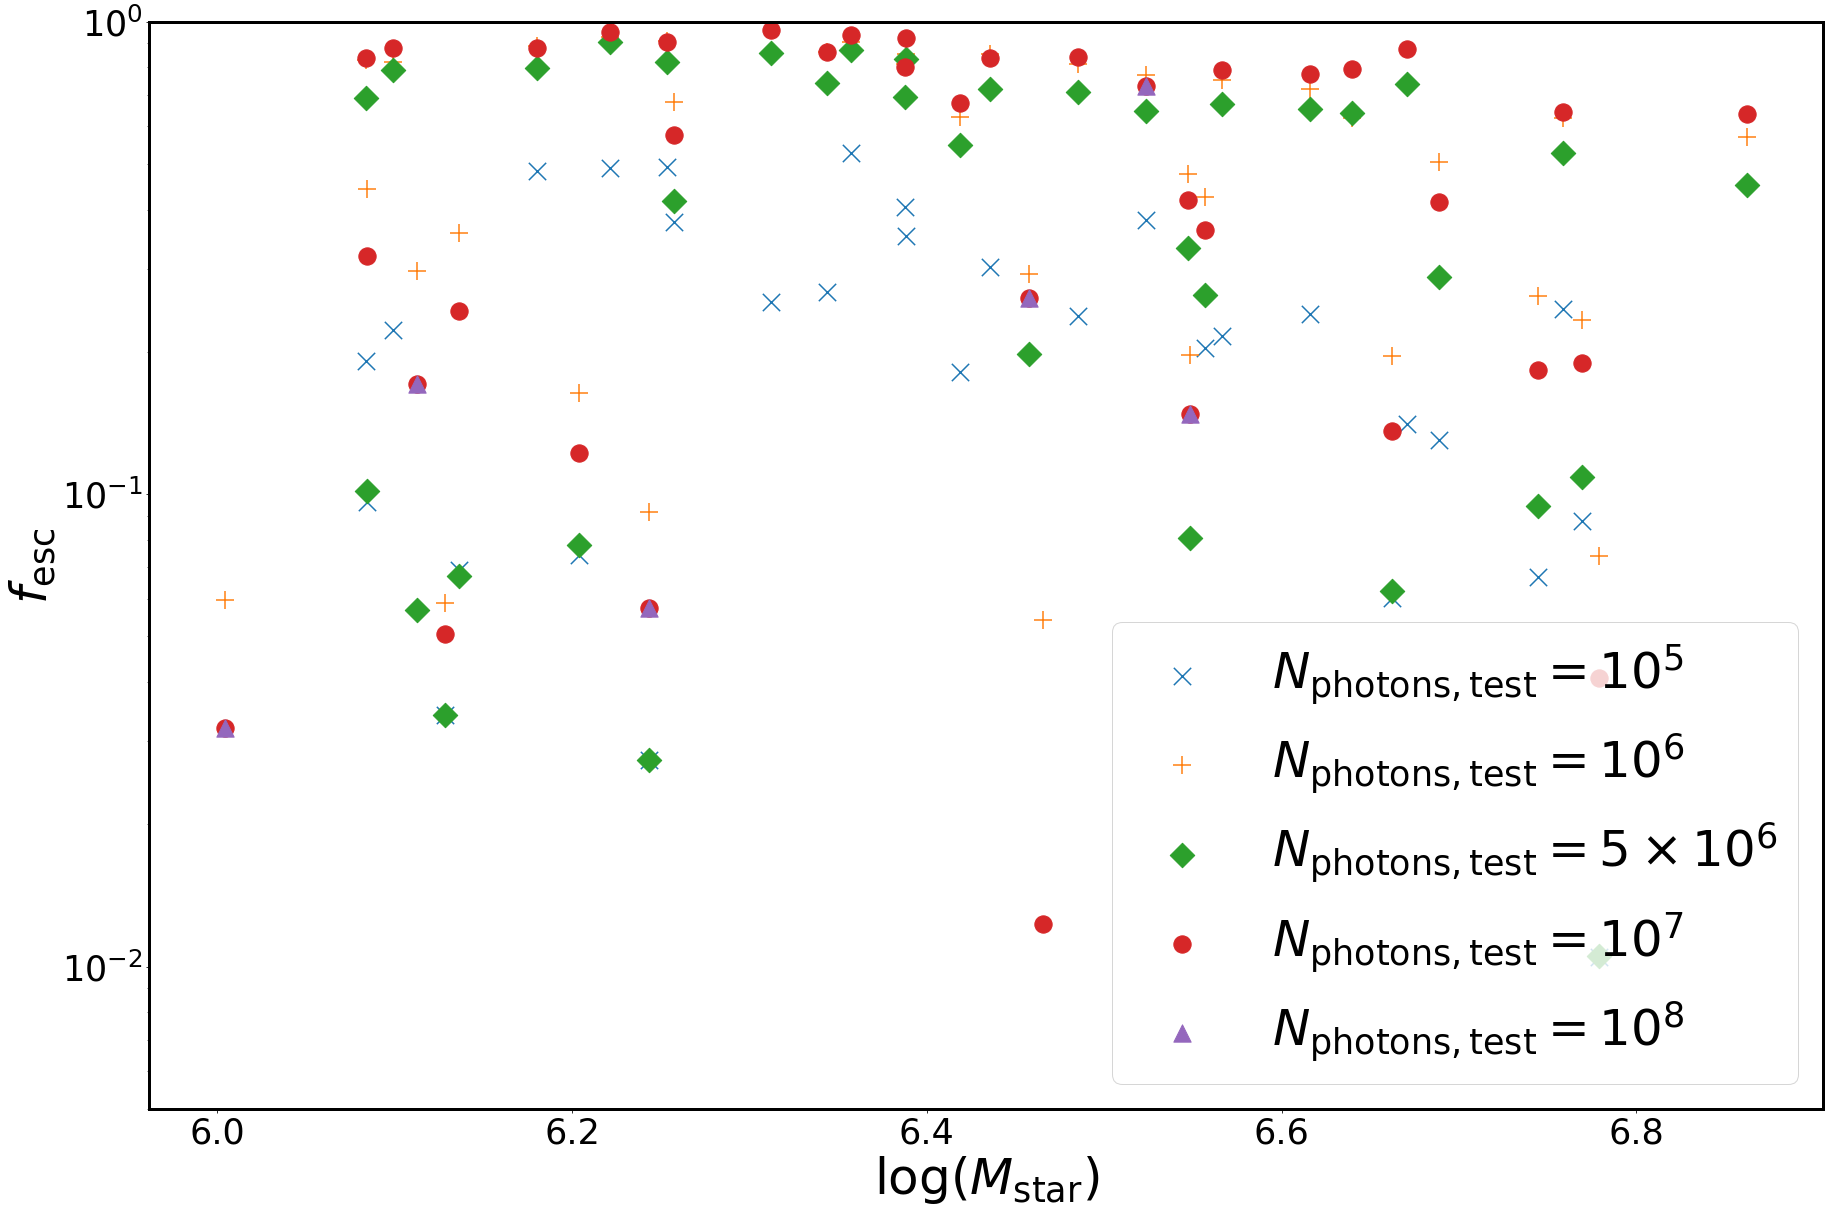

In [384]:
x_values = np.log10(conv_1e5.StarMass)
y_values = conv_1e5.f_esc
plt.scatter(x_values, y_values, s=300, marker='x', label='$N_\mathrm{photons, test}=10^5$')

x_values = np.log10(conv_1e6.StarMass)
y_values = conv_1e6.f_esc
plt.scatter(x_values, y_values, s=300, marker='+', label=r'$N_\mathrm{photons, test}=10^6$')

x_values = np.log10(conv_5e6.StarMass)
y_values = conv_5e6.f_esc
plt.scatter(x_values, y_values, s=300, marker='D', label=r'$N_\mathrm{photons, test}=5 \times 10^6$')

x_values = np.log10(conv_1e7.StarMass)
y_values = conv_1e7.f_esc
plt.scatter(x_values, y_values, s=300, marker='o', label=r'$N_\mathrm{photons, test}=10^7$')


x_values = np.log10(conv_1e8.StarMass)
y_values = conv_1e8.f_esc
plt.scatter(x_values, y_values, s=300, marker='^', label=r'$N_\mathrm{photons, test}=10^8$')

plt.ylabel(r'$f_\mathrm{esc}$', size=50)
plt.xlabel(r'$\log(M_\mathrm{star})$', size=50)
plt.rcParams["figure.figsize"] = (30, 20)
plt.yscale('log')
plt.rcParams["figure.figsize"] = (30, 20)
plt.legend(fontsize=50)
plt.ylim(0.005,1);

In [385]:
test_1e6 = pd.read_pickle('dfs/convergence_test_1e6.pickle')
test_5e6 = pd.read_pickle('dfs/new_numerical_5e6.pickle')
test_1e7 = pd.read_pickle('dfs/convergence_test_1e7.pickle')
test_1e8 = pd.read_pickle('dfs/convergence_test_1e8.pickle')

update_df(test_1e6)
update_df(test_5e6)
update_df(test_1e7)
update_df(test_1e8)

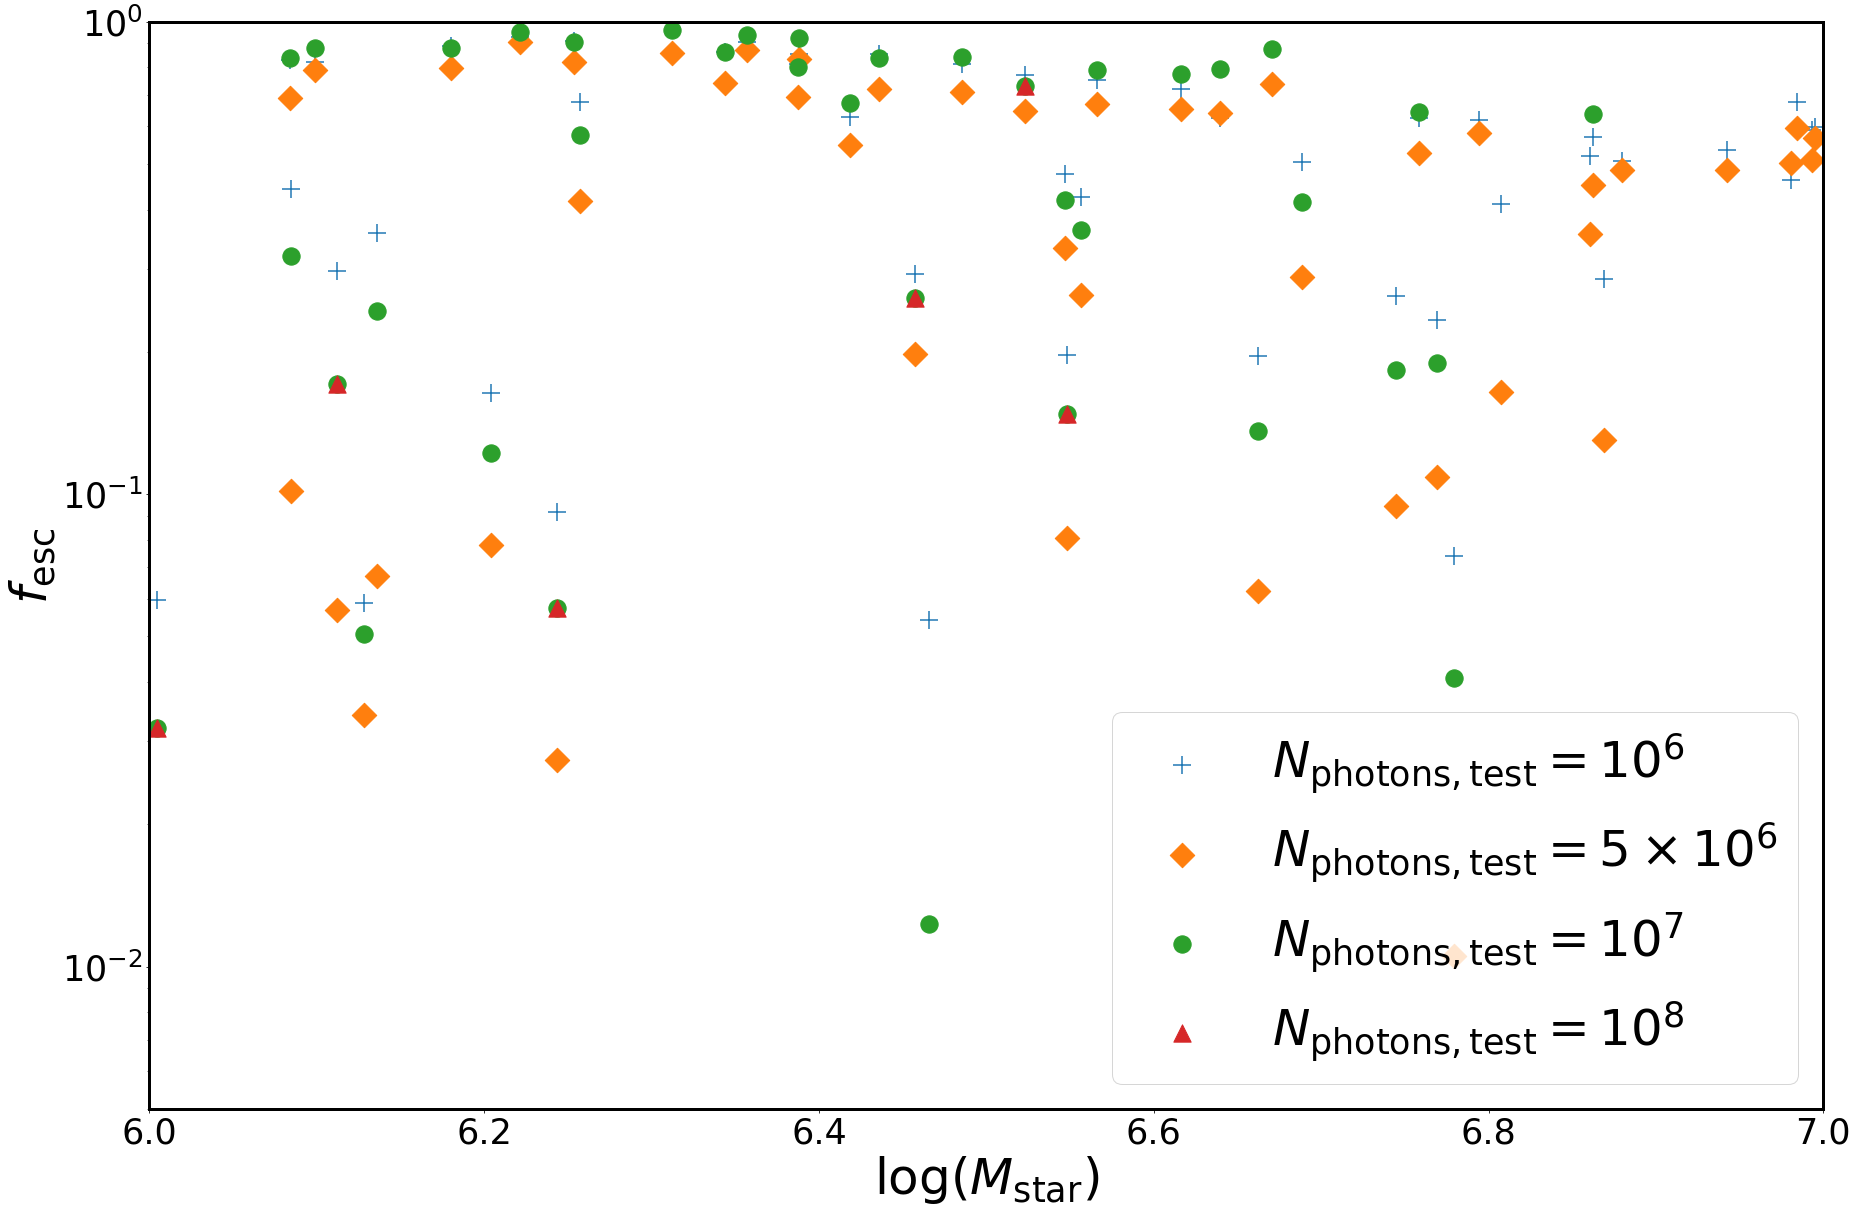

In [387]:
x_values = np.log10(test_1e6.StarMass)
y_values = test_1e6.f_esc
plt.scatter(x_values, y_values, s=300, marker='+', label=r'$N_\mathrm{photons, test}=10^6$')

x_values = np.log10(test_5e6.StarMass)
y_values = test_5e6.f_esc
plt.scatter(x_values, y_values, s=300, marker='D', label=r'$N_\mathrm{photons, test}=5 \times 10^6$')

x_values = np.log10(test_1e7.StarMass)
y_values = test_1e7.f_esc
plt.scatter(x_values, y_values, s=300, marker='o', label=r'$N_\mathrm{photons, test}=10^7$')


x_values = np.log10(test_1e8.StarMass)
y_values = test_1e8.f_esc
plt.scatter(x_values, y_values, s=300, marker='^', label=r'$N_\mathrm{photons, test}=10^8$')

plt.ylabel(r'$f_\mathrm{esc}$', size=50)
plt.xlabel(r'$\log(M_\mathrm{star})$', size=50)
plt.rcParams["figure.figsize"] = (30, 20)
plt.yscale('log')
plt.rcParams["figure.figsize"] = (30, 20)
plt.legend(fontsize=50)
plt.ylim(0.005,1)
plt.xlim(6,7);

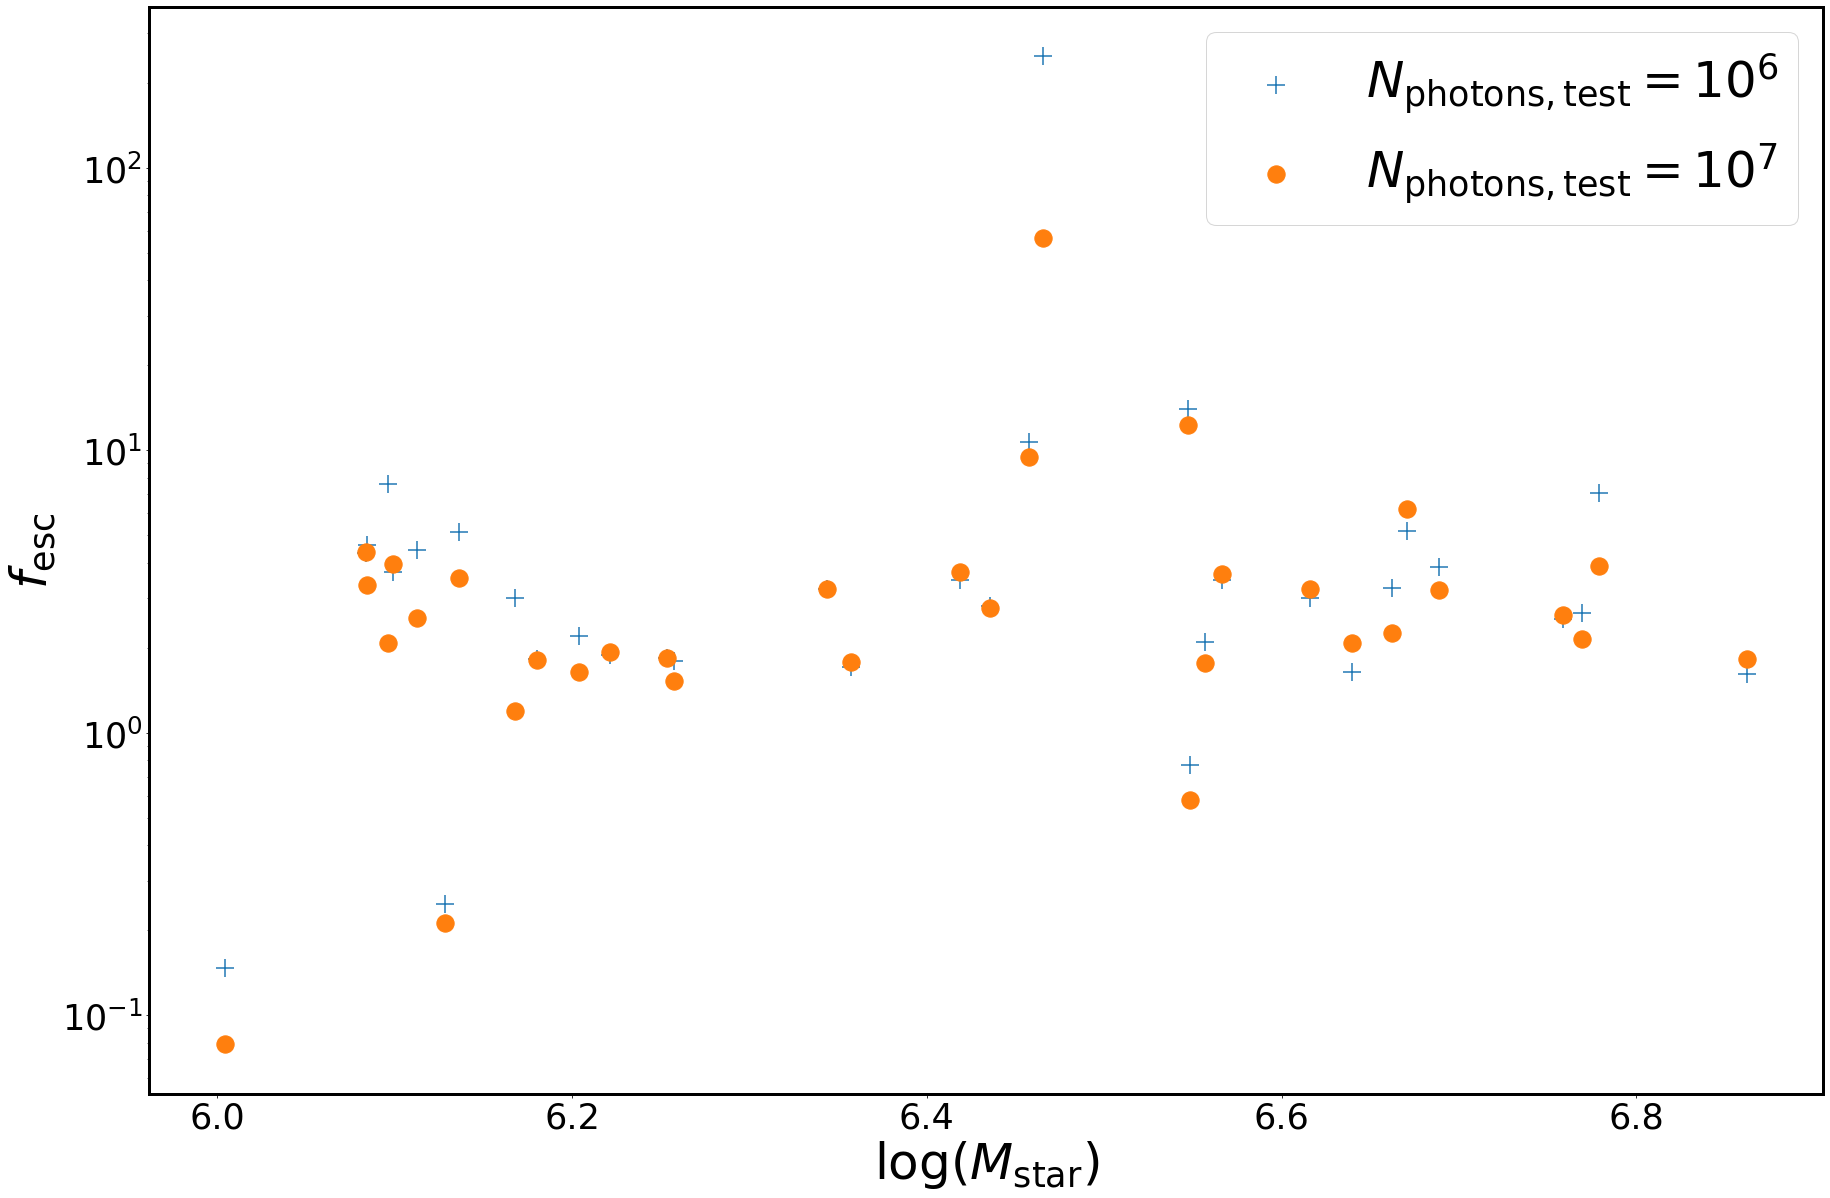

In [382]:
# x_values = np.log10(conv_1e5.StarMass)
# y_values = conv_1e5.f_esc
# plt.scatter(x_values, y_values, s=300, marker='x', label='$N_\mathrm{photons, test}=10^5$')

x_values = np.log10(conv_1e6.StarMass)
y_values = conv_1e6.f_esc/conv_1e5.f_esc
plt.scatter(x_values, y_values, s=300, marker='+', label=r'$N_\mathrm{photons, test}=10^6$')

x_values = np.log10(conv_1e7.StarMass)
y_values = conv_1e7.f_esc/conv_1e5.f_esc
plt.scatter(x_values, y_values, s=300, marker='o', label=r'$N_\mathrm{photons, test}=10^7$')


# x_values = np.log10(conv_1e8.StarMass)
# y_values = conv_1e8.f_esc
# plt.scatter(x_values, y_values, s=300, marker='^', label=r'$N_\mathrm{photons, test}=10^8$')

plt.ylabel(r'$f_\mathrm{esc}$', size=50)
plt.xlabel(r'$\log(M_\mathrm{star})$', size=50)
plt.rcParams["figure.figsize"] = (30, 20)
plt.yscale('log')
plt.legend(fontsize=50);
#plt.ylim(0.005,1);


In [ ]:
from crashpy.dataclasses.simulation import LoadedSimulation as Sim
from crashpy.escapeFraction import computeEscFrac
from multiprocessing import Pool
from crashpy import utilities
import h5py

seed = 42

compute_f_esc(prec=config.f_esc_prec, r_scales=config.f_esc_rscales, overwrite=config.f_esc_overwrite)
simpath_1e5  = '/freya/ptmp/mpa/mglatzle/TNG_f_esc/full_esc/run/L35n2160TNG/sn008/g1401'
simpath_5e6  = '/freya/ptmp/mpa/mglatzle/TNG_f_esc/new_numerical_5e6/run/L35n2160TNG/sn008/g1401'

sim_1e5 = Sim(simpath_1e5)
sim_6e6 = Sim(simpath_5e6)

physfiles_1e5 = sim_1e5.getAllphysfiles()
physfiles_1e5 = sim_5e6.getAllphysfiles()

r = computeEscFrac(sim, physfileNumber=physfile.info['number'],
                               delta_rel=prec, r_scale=r_scale,
                               n_threads=config.f_esc_threads,
                               seed=seed)
def compute_f_esc(simpath, prec, r_scales, overwrite=False):
    sim = Sim(simpath)
    prec_str = utilities.siunitStr(prec, 1, leading_one=True)

    out_string = []
    for physfile in sim.getAllphysfiles():
        outfile = config.f_esc_file(physfile)
        for r_scale in r_scales:
            rscale_str = utilities.siunitStr(r_scale, 1, leading_one=True)
            if os.path.isfile(outfile):
                with h5py.File(outfile, 'r') as ff:
                    if prec_str in ff:
                        if rscale_str in ff[prec_str] and not overwrite:
                            out_string.append(
                                f"Physfile {physfile.getNumber()}: Nothing to do."
                            )
                            continue

            r = computeEscFrac(sim, physfileNumber=physfile.info['number'],
                               delta_rel=prec, r_scale=r_scale,
                               n_threads=config.f_esc_threads,
                               seed=config.f_esc_seed)
            with h5py.File(outfile, 'a') as ff:
                if prec_str not in ff:
                    ff.create_group(prec_str)
                if rscale_str not in ff[prec_str]:
                    ff[prec_str].create_group(rscale_str)
                for key in r.keys():
                    if key in ff[prec_str][rscale_str]:
                        del ff[prec_str][rscale_str][key]
                    ff[prec_str][rscale_str][key] = r[key]
            out_string.append(
                f"Physfile {physfile.getNumber()}: "
                f"Number of iterations: {r['n_iterations']} "
                f"f_esc_cum: {r['cum']}",
            )
    print(simpath, "\n\t"+"\n\t".join(out_string))
    return


with open('00_f_esc.txt', 'r') as f:
    sims = [x.strip() for x in f.readlines()]

func = functools.partial(
    compute_f_esc,
    prec=config.f_esc_prec,
    r_scales=config.f_esc_rscales,
    overwrite=config.f_esc_overwrite
)

pool = Pool(processes=config.f_esc_processes)
pool.map(func, sims)


In [127]:
comparison_df3[comparison_df3.f_esc_5e6/comparison_df3.f_esc_1e5>5.0]

,ID,z,HaloMass,Metallicity,GasMetallicity,FractionStars,FractionGas,GasMassGrid,DustMass,Q0,...,n_iterations,per_freq_0_2,per_source_0_2,emitted_photons_0_2,escaped_photons_0_2,frequencies_0_2,n_iterations_0_2,f_esc_5e6,per_freq_5e6,StarMass
6,5037,6,0.588333,0.001064,0.000540,0.001779,0.094037,0.059083,0.000011,4.456650e+52,...,2,"[0.047794490064705826, 0.04793517559226395, 0....","[4.754898505501186e-05, 1.8506859936710374e-05...","[[0.05570539199448463, 8.625614067004261e-05, ...","[[6.636876255529357e-20, 1.0743371367007147e-2...","[3288593900000000.0, 3290420400000000.5, 32939...",2,0.586432,"[0.42448926573425877, 0.4346304950142938, 0.44...",1.545037e+07
13,1812,6,1.233295,0.001120,0.000466,0.001696,0.102142,0.060650,0.000014,3.546094e+52,...,2,"[0.011503361052480695, 0.01320679370540608, 0....","[4.051424631431903e-08, 4.261819366983614e-08,...","[[0.0021493091425266583, 5.184015831815015e-05...","[[1.807534081864991e-28, 4.675404729891466e-30...","[3288593900000000.0, 3290420400000000.5, 32939...",2,0.518824,"[0.32844109416796236, 0.35264817320313324, 0.3...",3.087744e+07
22,8727,6,0.403137,0.001629,0.000538,0.001654,0.075414,0.077402,0.000016,2.435026e+52,...,2,"[0.038428033149670915, 0.04130353072921572, 0....","[6.319890017556482e-15, 1.2818924759706143e-16...","[[0.00023923531703367578, 4.168837423560199e-0...","[[0.0, 0.0, 5.739959277316766e-17, 1.318279407...","[3288593900000000.0, 3290420400000000.5, 32939...",2,0.510517,"[0.35702631392764733, 0.3741844783363391, 0.38...",9.840703e+06
28,2634,8,0.407304,0.001038,0.000613,0.001605,0.061662,0.054610,0.000010,3.873100e+52,...,2,"[0.11368140861392462, 0.10322012455728541, 0.0...","[5.6004960400605175e-05, 9.049217202418847e-14...","[[0.002170056247099909, 0.00019050163116798684...","[[5.570726875800398e-19, 0.0, 8.9495e-320, 0.0...","[3288593900000000.0, 3290420400000000.5, 32939...",2,0.595863,"[0.45234885257139024, 0.45541690299228677, 0.4...",9.649381e+06
29,5604,8,0.248426,0.000833,0.000624,0.001278,0.056549,0.017106,0.000004,2.085526e+52,...,2,"[0.21404970275258597, 0.22414218946072045, 0.2...","[0.025478282429728768, 1.0146624834297937e-09,...","[[0.0002963139152924106, 1.1665794966956124e-0...","[[1.0404227814088584e-07, 3.859265760090883e-1...","[3288593900000000.0, 3290420400000000.5, 32939...",2,0.737339,"[0.6120464797392481, 0.6261222947766625, 0.637...",4.685578e+06
30,1029,8,0.717924,0.000751,0.000471,0.001391,0.082873,0.027148,0.000007,1.494236e+52,...,2,"[0.001602472583643631, 0.0012697223224532761, ...","[1.254899896900364e-16, 0.00037141845703408716...","[[0.0019661438206503034, 1.5481822611183111, 0...","[[0.0, 6.350682256548059e-07, 9.94801011868374...","[3288593900000000.0, 3290420400000000.5, 32939...",2,0.198295,"[0.09612461589303438, 0.10401045264187629, 0.1...",1.474065e+07
37,2310,8,0.435562,0.000776,0.000568,0.001362,0.068621,0.047753,0.000008,2.858595e+52,...,2,"[0.03418339135189543, 0.03374556337730532, 0.0...","[0.019824418679201948, 3.5571878107051697e-10,...","[[0.14971870946339638, 6.978487415870767e-05, ...","[[0.0005946929102573956, 0.0, 9.20383442835944...","[3288593900000000.0, 3290420400000000.5, 32939...",2,0.484773,"[0.3519498037810766, 0.35814143110631563, 0.36...",8.758931e+06
39,3203,8,0.361112,0.000980,0.000495,0.001168,0.059224,0.023560,0.000004,2.931599e+52,...,2,"[0.05061898476966029, 0.05355160133668215, 0.0...","[0.005192987703965695, 2.1031742187257818e-05,...","[[0.0026078159131523496, 0.30420449560053525, ...","[[3.501369364141462e-09, 1.0180336359419678e-1...","[3288593900000000.0, 3290420400000000.5, 32939...",2,0.580679,"[0.39562346819866956, 0.41564053958176317, 0.4...",6.225186e+06
41,897,8,0.781127,0.001530,0.000696,0.002148,0.081880,0.306156,0.000066,5.680088e+52,...,2,"[0.011950909854827697, 0.010456715600384688, 0...","[2.455448647779852e-25, 5.631373082176217e-25,...","[[0.0001015166973710162, 0.002738382110024586,...","[[0.0, 0.0, 0.0, 1.964112744323128e-99, 0.0, 0...","[3288593900000000.0, 32904204000000

In [107]:
comparison_df3[comparison_df3.ID==2537]

,ID,z,HaloMass,Metallicity,GasMetallicity,FractionStars,FractionGas,GasMassGrid,DustMass,Q0,...,n_iterations,per_freq_0_2,per_source_0_2,emitted_photons_0_2,escaped_photons_0_2,frequencies_0_2,n_iterations_0_2,f_esc_5e6,per_freq_5e6,StarMass


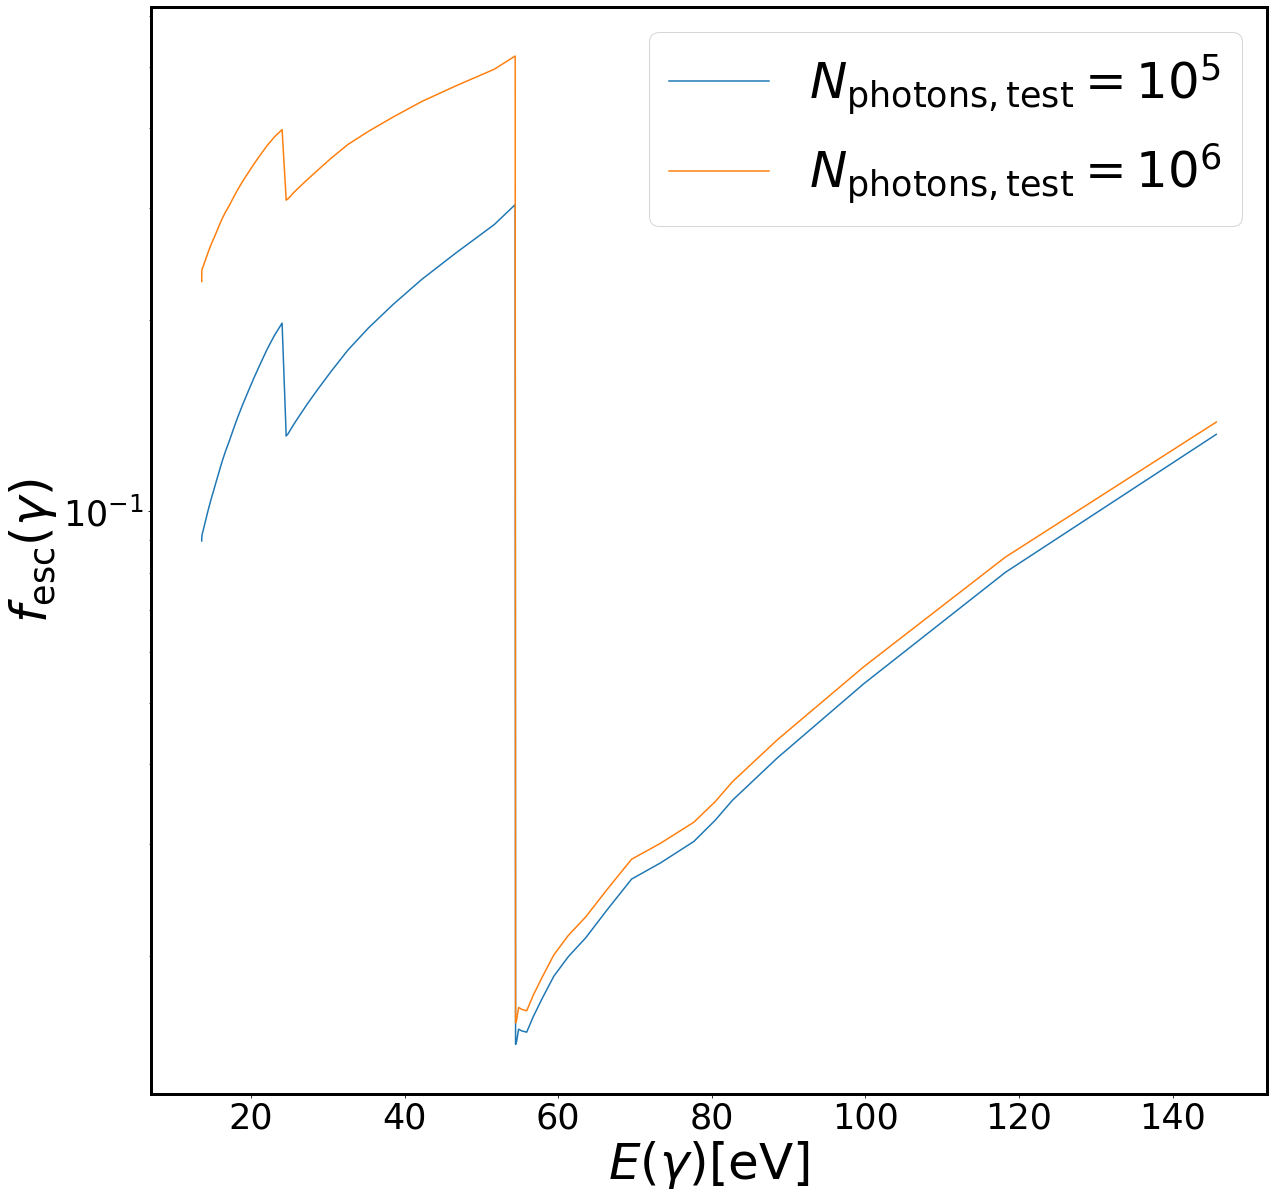

In [104]:
h_p = 6.62607004e-34
e = 1.60217662e-19

y_values_1e6 = np.zeros(len(comparison_df2.iloc[0].per_freq_1e5))
y_values_1e5 = np.zeros(len(comparison_df2.iloc[0].per_freq_1e5))
for i in range(len(comparison_df2)):
    y_values_1e6 += np.array(comparison_df2.iloc[i].per_freq_1e6)
    y_values_1e5 += np.array(comparison_df2.iloc[i].per_freq_1e5)
    
y_values_1e6/=len(comparison_df2)
y_values_1e5/=len(comparison_df2)
    
x_values = comparison_df2.iloc[0].frequencies*h_p/e
plt.plot(x_values, y_values_1e5, label='$N_\mathrm{photons, test}=10^5$')

x_values = comparison_df2.iloc[0].frequencies*h_p/e
plt.plot(x_values, y_values_1e6, label=r'$N_\mathrm{photons, test}=10^6$')
plt.ylabel(r'$f_\mathrm{esc}(\gamma)$', size=50)
plt.xlabel(r'$E(\gamma)[\mathrm{eV}]$', size=50)
plt.yscale('log')
plt.legend(fontsize=50);
#plt.ylim(0.9,100);

In [52]:
x_values = np.log10(comparison_df2.StarMass)
y_values = comparison_df2.f_esc_1e6/comparison_df2.f_esc_1e5
plt.scatter(x_values, y_values, s=300, marker='+', label='$N_\mathrm{photons, test}=10^6$')

x_values = np.log10(comparison_df3.StarMass)
y_values = comparison_df3.f_esc_5e6/comparison_df3.f_esc_1e5
plt.scatter(x_values, y_values, s=300, marker='^', label=r'$N_\mathrm{photons, test}=5 \times 10^6$')
plt.ylabel(r'$\frac{f_\mathrm{esc, test}}{f_\mathrm{esc}}$', size=50)
plt.xlabel(r'$\log(M_\mathrm{star})$', size=50)
plt.yscale('log')
plt.legend(fontsize=50)
plt.ylim(0.9,100);

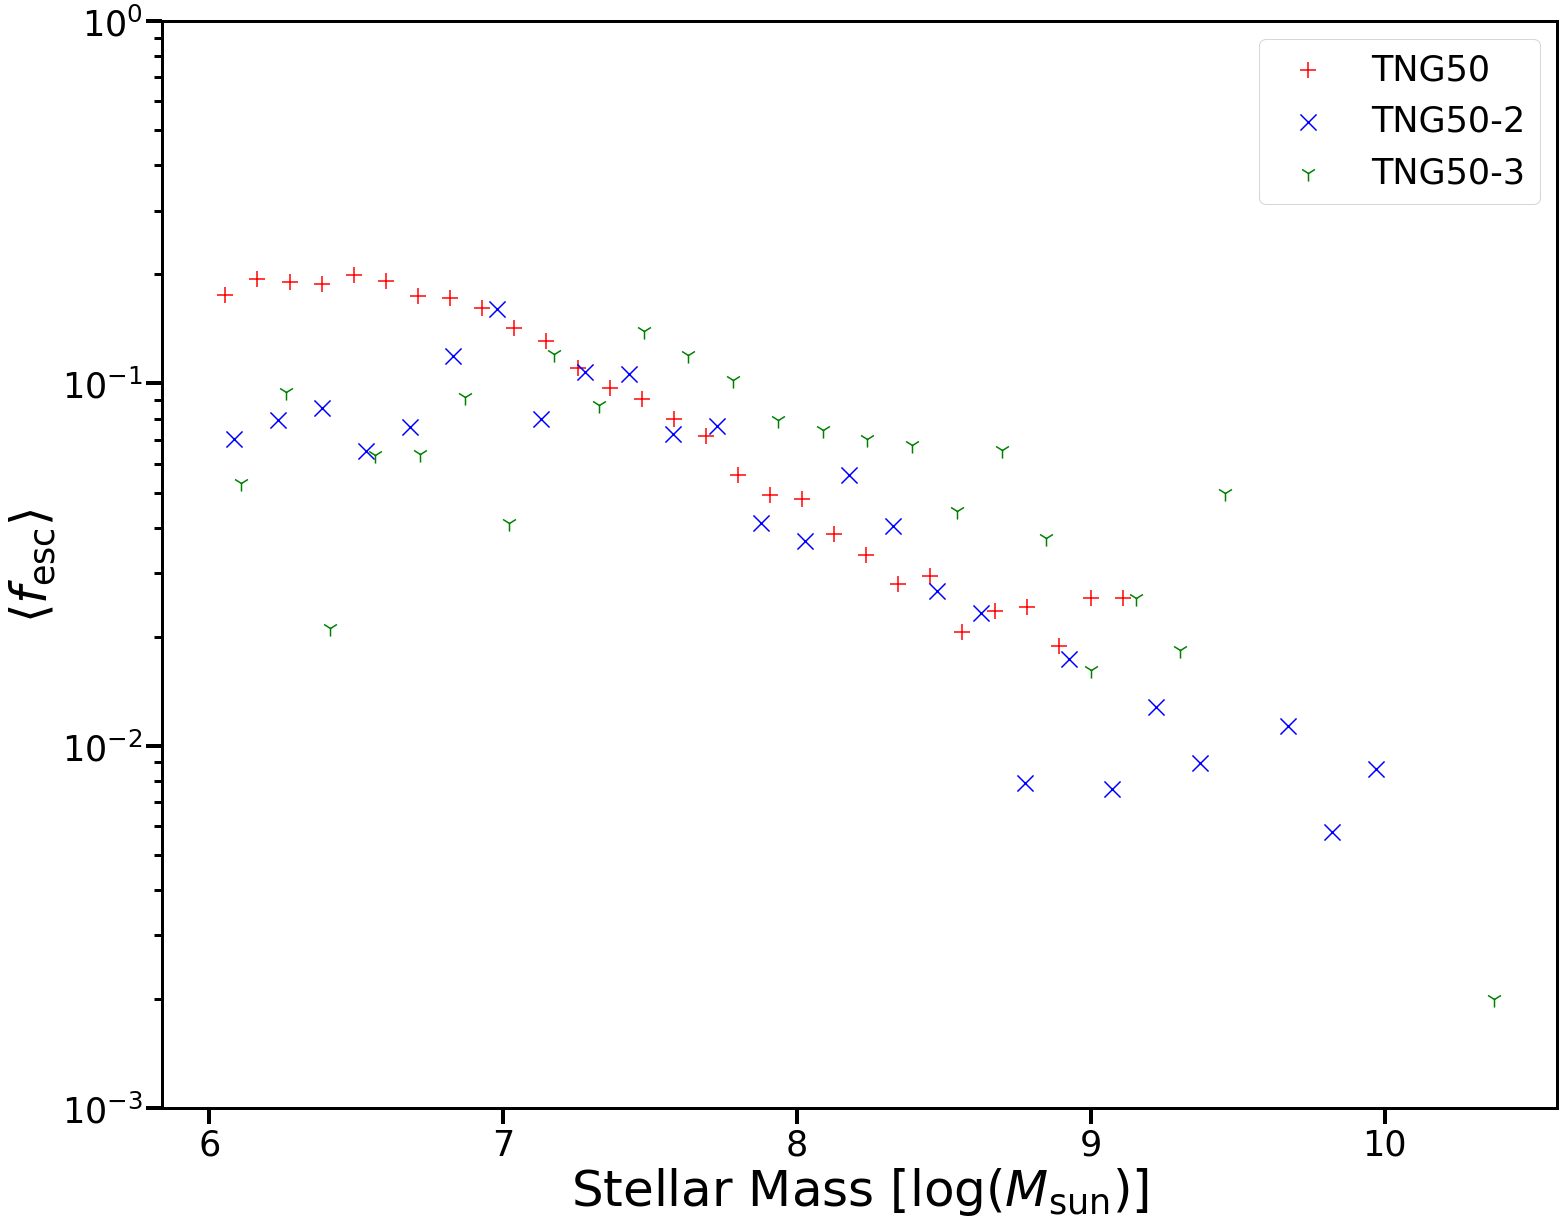

In [42]:
plot_tng_comparison(dfs, halo_prop='StarMass', bins=30, mode='mean', y_threshold=1e-3, save=True)

In [247]:
update_df(df_5e6)

In [258]:
halos_z6 = np.array(df_5e6[(df_5e6.StarMass<1e7) & (df_5e6.z==6)].ID)
halos_z8 = np.array(df_5e6[(df_5e6.StarMass<1e7) & (df_5e6.z==8)].ID)
halos_z10 = np.array(df_5e6[(df_5e6.StarMass<1e7) & (df_5e6.z==10)].ID)

array([25191,  4238, 22258, 20088, 61869, 33619, 41526, 24258,  5500,
       20279, 20915, 34017, 19512, 62846,  8727, 21424, 17206, 40553])

In [264]:
import os

In [275]:
id_dic = {10:halos_z10, 8:halos_z8, 6:halos_z6}
snap_dic = {10:'sn004', 8:'sn008', 6:'sn013'}
redshifts = [10,8,6]
numerical_tests = [6,7,8]
column_names=['x', 'y', 'z', 'a', 'Q', 'b', 'name', 'c','halo', 'd', 'packets', 'e', 'loc_uv', 'f', 'loc_x']
bin_origin = '/ptmp/mpa/mglatzle/TNG_f_esc/new_numerical_5e6/bin'
db_origin = '/ptmp/mpa/mglatzle/TNG_f_esc/new_numerical_5e6/db'

In [276]:
for packet_ex in numerical_tests:
    packets = f'1.000d+0{packet_ex}'
    setting_dir = f'/ptmp/mpa/mglatzle/TNG_f_esc/convergence_test_1e{packet_ex}'
    os.system(f'cp -r {bin_origin} {setting_dir}')
    os.system(f'cp -r {db_origin} {setting_dir}')
    for z in redshifts:
        print(f'Working on {packet_ex} and redshift {z}')
        snap = snap_dic[z]
        origin_dir = f'/ptmp/mpa/mglatzle/TNG_f_esc/new_numerical_5e6/input/L35n2160TNG/{snap}'
        input_dir = f'/ptmp/mpa/mglatzle/TNG_f_esc/convergence_test_1e{packet_ex}/input/L35n2160TNG/{snap}'
        
        selected_halos_path = os.path.join(input_dir, 'selected_halos.npy')
        halos_to_use = id_dic[z]
        np.save(selected_halos_path, halos_to_use)
        
        halo_catalog_origin = os.path.join(origin_dir, 'sel_halos_df.pickle')
        os.system(f'cp {halo_catalog_origin} {input_dir}')
        
        for halo in halos_to_use:
            print(f'Working on halo {halo}')
            halo_origin = os.path.join(origin_dir, f'g{halo}')
            os.system(f'cp -r {halo_origin} {input_dir}')
            
            halo_dest = os.path.join(input_dir, f'g{halo}')
            sources_path = os.path.join(halo_dest, 'sources_ic00.in')
            sources = pd.read_table(sources_path, delimiter='\t', names=column_names)
            sources.packets = packets
            sources.to_csv(sources_path, sep='\t', header=False, index=False)

0

0

Working on 6 and redshift 10


0

Working on halo 7348


0

Working on halo 6053


0

Working on halo 758


0

Working on halo 825


0

Working on halo 872


0

Working on halo 2048


0

Working on halo 3995


0

Working on halo 2184


0

Working on halo 2302


0

Working on halo 611


0

Working on halo 3854


0

Working on halo 1415


0

Working on halo 4276


0

Working on 6 and redshift 8


0

Working on halo 4679


0

Working on halo 2634


0

Working on halo 5604


0

Working on halo 2149


0

Working on halo 2226


0

Working on halo 16090


0

Working on halo 4994


0

Working on halo 2268


0

Working on halo 17656


0

Working on halo 2310


0

Working on halo 3203


0

Working on halo 10638


0

Working on halo 7984


0

Working on halo 5970


0

Working on halo 3837


0

Working on halo 1940


0

Working on halo 1201


0

Working on halo 2397


0

Working on halo 12909


0

Working on 6 and redshift 6


0

Working on halo 25191


0

Working on halo 4238


0

Working on halo 22258


0

Working on halo 20088


0

Working on halo 61869


0

Working on halo 33619


0

Working on halo 41526


0

Working on halo 24258


0

Working on halo 5500


0

Working on halo 20279


0

Working on halo 20915


0

Working on halo 34017


0

Working on halo 19512


0

Working on halo 62846


0

Working on halo 8727


0

Working on halo 21424


0

Working on halo 17206


0

Working on halo 40553


0

0

0

Working on 7 and redshift 10


0

Working on halo 7348


0

Working on halo 6053


0

Working on halo 758


0

Working on halo 825


0

Working on halo 872


0

Working on halo 2048


0

Working on halo 3995


0

Working on halo 2184


0

Working on halo 2302


0

Working on halo 611


0

Working on halo 3854


0

Working on halo 1415


0

Working on halo 4276


0

Working on 7 and redshift 8


0

Working on halo 4679


0

Working on halo 2634


0

Working on halo 5604


0

Working on halo 2149


0

Working on halo 2226


0

Working on halo 16090


0

Working on halo 4994


0

Working on halo 2268


0

Working on halo 17656


0

Working on halo 2310


0

Working on halo 3203


0

Working on halo 10638


0

Working on halo 7984


0

Working on halo 5970


0

Working on halo 3837


0

Working on halo 1940


0

Working on halo 1201


0

Working on halo 2397


0

Working on halo 12909


0

Working on 7 and redshift 6


0

Working on halo 25191


0

Working on halo 4238


0

Working on halo 22258


0

Working on halo 20088


0

Working on halo 61869


0

Working on halo 33619


0

Working on halo 41526


0

Working on halo 24258


0

Working on halo 5500


0

Working on halo 20279


0

Working on halo 20915


0

Working on halo 34017


0

Working on halo 19512


0

Working on halo 62846


0

Working on halo 8727


0

Working on halo 21424


0

Working on halo 17206


0

Working on halo 40553


0

0

0

Working on 8 and redshift 10


0

Working on halo 7348


0

Working on halo 6053


0

Working on halo 758


0

Working on halo 825


0

Working on halo 872


0

Working on halo 2048


0

Working on halo 3995


0

Working on halo 2184


0

Working on halo 2302


0

Working on halo 611


0

Working on halo 3854


0

Working on halo 1415


0

Working on halo 4276


0

Working on 8 and redshift 8


0

Working on halo 4679


0

Working on halo 2634


0

Working on halo 5604


0

Working on halo 2149


0

Working on halo 2226


0

Working on halo 16090


0

Working on halo 4994


0

Working on halo 2268


0

Working on halo 17656


0

Working on halo 2310


0

Working on halo 3203


0

Working on halo 10638


0

Working on halo 7984


0

Working on halo 5970


0

Working on halo 3837


0

Working on halo 1940


0

Working on halo 1201


0

Working on halo 2397


0

Working on halo 12909


0

Working on 8 and redshift 6


0

Working on halo 25191


0

Working on halo 4238


0

Working on halo 22258


0

Working on halo 20088


0

Working on halo 61869


0

Working on halo 33619


0

Working on halo 41526


0

Working on halo 24258


0

Working on halo 5500


0

Working on halo 20279


0

Working on halo 20915


0

Working on halo 34017


0

Working on halo 19512


0

Working on halo 62846


0

Working on halo 8727


0

Working on halo 21424


0

Working on halo 17206


0

Working on halo 40553


0